# Music Streaming Churn Prediction Model
### Project by Aantriksh Sood

Dataset: https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the JSON file into a DataFrame
df = pd.read_json('/home/zero/Desktop/AIML/mini_sparkify_event_data.json', lines=True)

# Display basic information about the dataset
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             286500 non-null  int64  
 1   userId         286500 non-null  object 
 2   sessionId      286500 non-null  int64  
 3   page           286500 non-null  object 
 4   auth           286500 non-null  object 
 5   method         286500 non-null  object 
 6   status         286500 non-null  int64  
 7   level          286500 non-null  object 
 8   itemInSession  286500 non-null  int64  
 9   location       278154 non-null  object 
 10  userAgent      278154 non-null  object 
 11  lastName       278154 non-null  object 
 12  firstName      278154 non-null  object 
 13  registration   278154 non-null  float64
 14  gender         278154 non-null  object 
 15  artist         228108 non-null  object 
 16  song           228108 non-null  object 
 17  length         228108 non-nul

# Data Clearning 

In [4]:
# Check for missing values
print(df.isnull().sum())
# Drop columns with high missing values
df = df.drop(['artist', 'song', 'length'], axis=1)
# Drop rows with missing `userId`
df = df.dropna(subset=['userId'])

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64


In [5]:
# Convert userId to string
df['userId'] = df['userId'].astype(str)

# Convert timestamp to datetime format
df['datetime'] = pd.to_datetime(df['ts'], unit='ms')

# Extract year, month, day, and hour for further analysis
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour


In [6]:
print(df['page'].unique())

['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings'
 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings'
 'Cancel' 'Cancellation Confirmation']


In [ ]:
print(df.describe())

                 ts      sessionId         status  itemInSession  \
count  2.865000e+05  286500.000000  286500.000000  286500.000000   
mean   1.540957e+12    1041.526555     210.054597     114.414213   
std    1.507544e+09     726.776263      31.505078     129.767262   
min    1.538352e+12       1.000000     200.000000       0.000000   
25%    1.539697e+12     336.000000     200.000000      27.000000   
50%    1.540932e+12    1013.000000     200.000000      70.000000   
75%    1.542266e+12    1675.000000     200.000000     156.250000   
max    1.543799e+12    2474.000000     404.000000    1321.000000   

       registration         length  
count  2.781540e+05  228108.000000  
mean   1.535359e+12     249.117182  
std    3.291322e+09      99.235179  
min    1.521381e+12       0.783220  
25%    1.533522e+12     199.888530  
50%    1.536664e+12     234.500770  
75%    1.537672e+12     277.158730  
max    1.543247e+12    3024.665670  


# Processing & Feature Engineering

In [8]:
df['churn'] = df['page'].apply(lambda x: 1 if x == 'Cancellation Confirmation' else 0)

# Aggregate churn data by user
user_churn = df.groupby('userId')['churn'].max().reset_index()
user_churn.columns = ['userId', 'churn']

print(user_churn.head())

   userId  churn
0      10      0
1     100      0
2  100001      1
3  100002      0
4  100003      1


In [13]:
# Aggregated user-level features
user_activity = df.groupby('userId').agg({
    'sessionId': 'nunique',          # Number of unique sessions
    'itemInSession': 'sum',           # Total items in session
    'page': lambda x: (x == 'NextSong').sum(),  # Total songs played
    'ts': 'max',                      # Last activity timestamp
}).reset_index()

# Rename columns for better readability
user_activity.columns = ['userId', 'num_sessions', 'total_items', 'total_songs', 'last_activity']

# Merge with churn data
user_activity = user_activity.merge(user_churn, on='userId', how='left')

print(user_activity.head())


   userId  num_sessions  total_items  total_songs  last_activity  churn
0      10             6       116260          673  1542631788000      0
1     100            35       287058         2682  1543587349000      0
2  100001             4         5332          133  1538498205000      1
3  100002             4        18198          195  1543799476000      0
4  100003             2         3171           51  1539274781000      1


In [18]:
"""
Time based features calculation
"""

# Calculate registration time from 'registration' column
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

# Calculate user tenure (in days) on the platform
df['tenure'] = (df['datetime'] - df['registration']).dt.days

# Average user tenure per user
user_tenure = df.groupby('userId')['tenure'].max().reset_index()
user_activity = user_activity.merge(user_tenure, on='userId', how='left')

print(user_activity.head())


   userId  sessionId             ts  churn  last_active_days  tenure
0      10        795  1542631788000      0             20034      51
1     100       3214  1543587349000      0             20034      64
2  100001        187  1538498205000      1             20034      44
3  100002        218  1543799476000      0             20034     160
4  100003         78  1539274781000      1             20034      22


In [23]:
# Gender and level encoding
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
df['level'] = df['level'].apply(lambda x: 1 if x == 'paid' else 0)

# Aggregate features
user_categorical = df.groupby('userId')[['gender', 'level']].max().reset_index()
user_activity = user_activity.merge(user_categorical, on='userId', how='left')

# output
print(user_activity.head())

   userId  sessionId             ts  churn  last_active_days  gender_x  \
0      10        795  1542631788000      0             20034         1   
1     100       3214  1543587349000      0             20034         1   
2  100001        187  1538498205000      1             20034         0   
3  100002        218  1543799476000      0             20034         0   
4  100003         78  1539274781000      1             20034         0   

   level_x  gender_y  level_y  
0        1         0        0  
1        1         0        0  
2        0         0        0  
3        1         0        0  
4        0         0        0  


# Standardisation & Normalisation

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select features to standardize and normalize
features_to_scale = ['total_items', 'total_songs', 'tenure']

# Scale features using StandardScaler
scaler = StandardScaler()
user_activity[features_to_scale] = scaler.fit_transform(user_activity[features_to_scale])

# Scale features using MinMaxScaler
minmax_scaler = MinMaxScaler()
user_activity[features_to_scale] = minmax_scaler.fit_transform(user_activity[features_to_scale])

print(user_activity.head())


   userId  num_sessions  total_items  total_songs  last_activity  churn  \
0      10             6     0.096259     0.083760  1542631788000      0   
1     100            35     0.237693     0.334917  1543587349000      0   
2  100001             4     0.004403     0.016252  1538498205000      1   
3  100002             4     0.015057     0.024003  1543799476000      0   
4  100003             2     0.002613     0.006001  1539274781000      1   

     tenure  gender  level  
0  0.199219       1      1  
1  0.250000       1      1  
2  0.171875       0      0  
3  0.625000       0      1  
4  0.085937       0      0  


# EDA ( Exploratory Data Anlaysis )

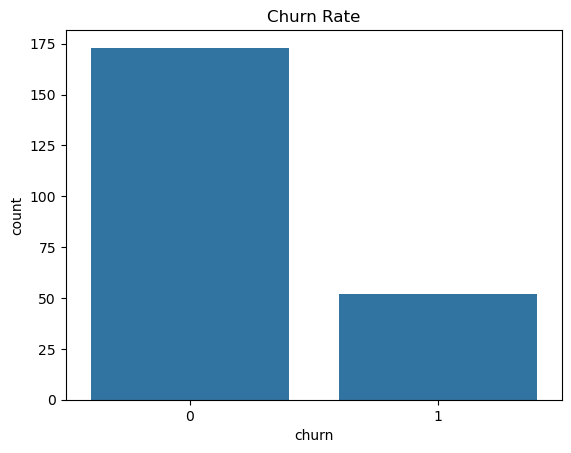

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='churn', data=user_activity)
plt.title('Churn Rate')
plt.show()

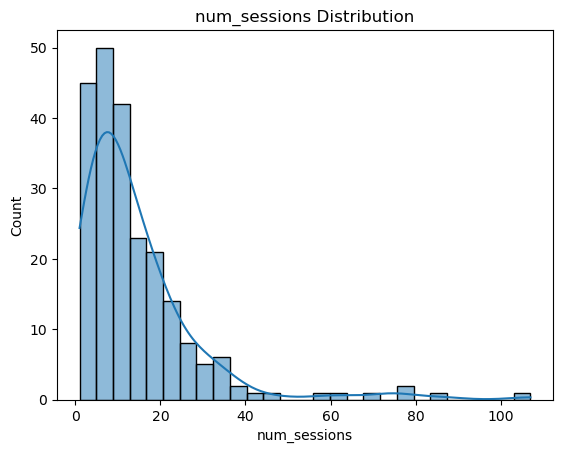

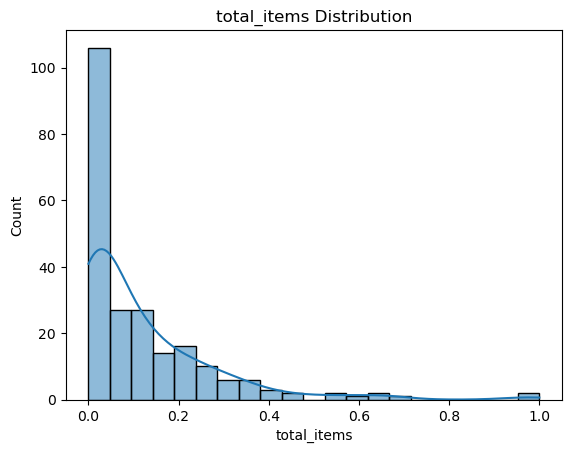

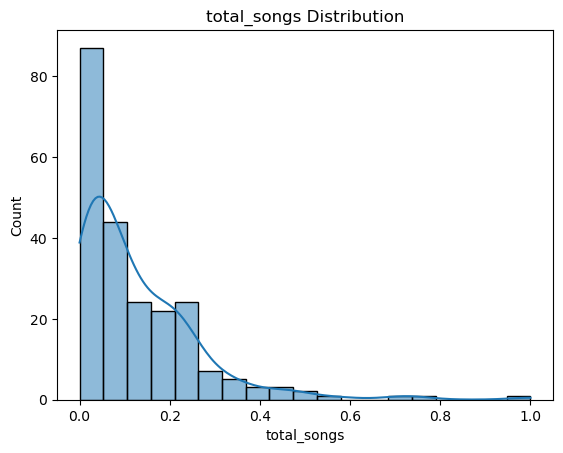

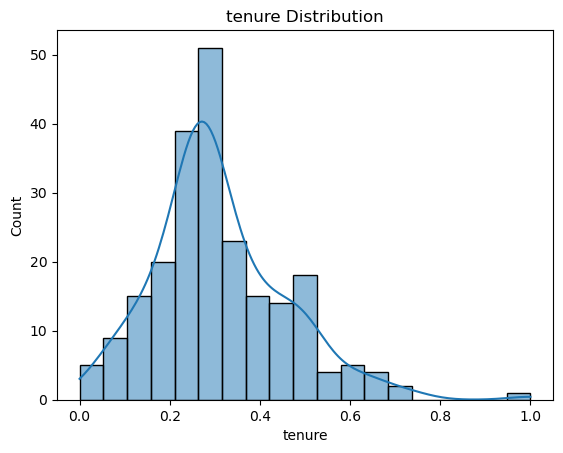

In [41]:
features_to_plot = ['num_sessions', 'total_items', 'total_songs', 'tenure']
for feature in features_to_plot:
    plt.figure()
    sns.histplot(user_activity[feature], kde=True)
    plt.title(f'{feature} Distribution')
    plt.show()

/home/zero/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


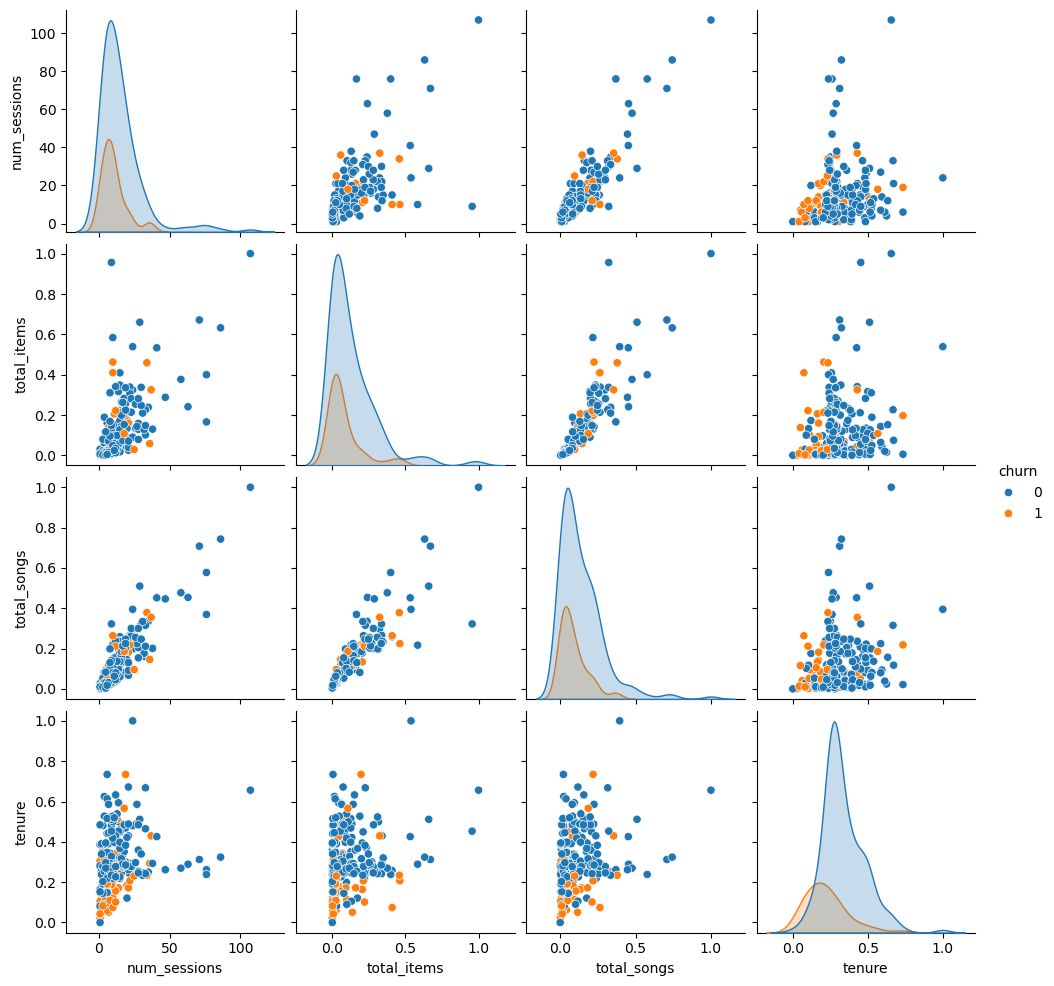

In [46]:
sns.pairplot(user_activity, hue="churn", vars=features_to_plot)
plt.show()

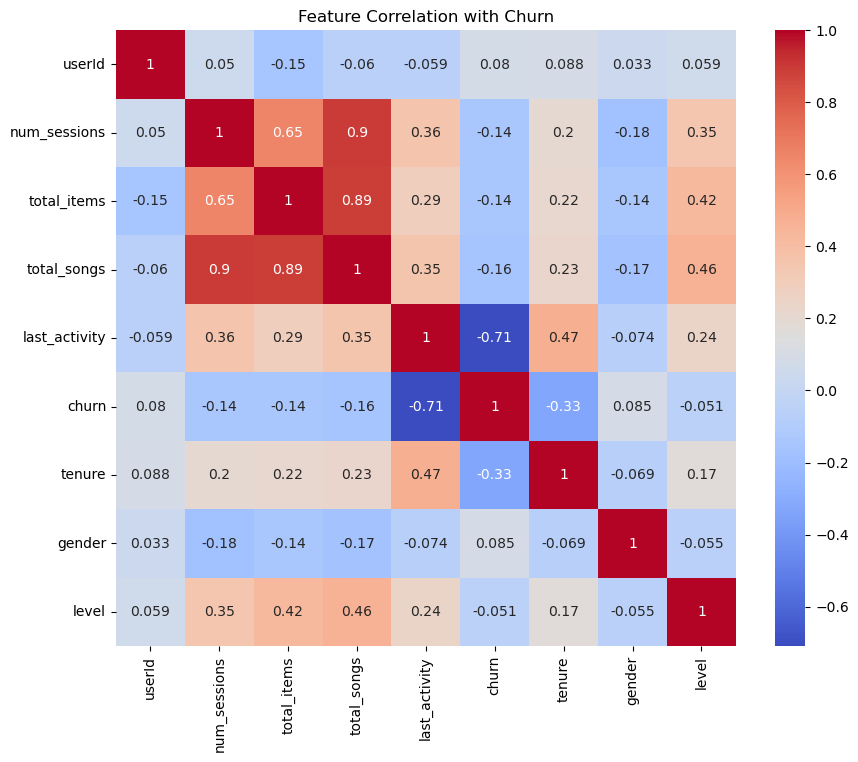

In [42]:
# Correlation matrix
corr = user_activity.corr()

# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Churn")
plt.show()

# Data Splitting

In [47]:
from sklearn.model_selection import train_test_split

# Define features and target
X = user_activity.drop(['userId', 'churn'], axis=1)
y = user_activity['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(180, 7) (45, 7) (180,) (45,)


# Model Building

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8222222222222222
Confusion Matrix:
 [[31  3]
 [ 5  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.67      0.55      0.60        11

    accuracy                           0.82        45
   macro avg       0.76      0.73      0.74        45
weighted avg       0.81      0.82      0.82        45



### Feature Importance for the Model

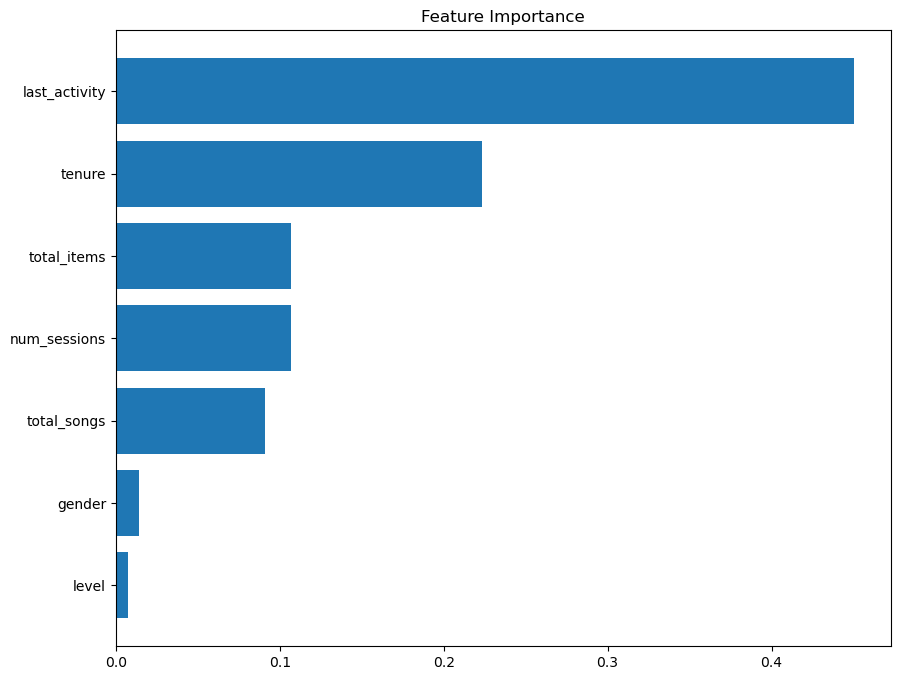

In [54]:
model = pipeline.named_steps['classifier']
importances = model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = importances.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.title("Feature Importance")
plt.show()
